In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import load_model

# PREPROCESS DATASET Wav -> Mel_Spectogram.png

In [5]:
# Check the dataset exist
dataset_path = 'Data\genres_original'

try:
    if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
        print("Folder Exist: ", dataset_path)
    else: 
        raise FileNotFoundError(f"Folder Not Found: {dataset_path}")
except FileNotFoundError as e:
    print("Error: ", e)


Folder Exist:  Data\genres_original


In [6]:
random_sample = 'Data/genres_original/blues/blues.00000.wav'
y, sr = librosa.load(random_sample, sr=None)

def plot_mel_spectrogram(y, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis = 'time', y_axis = 'mel')
    plt.title("Mel_spectrogram")
    plt.show()

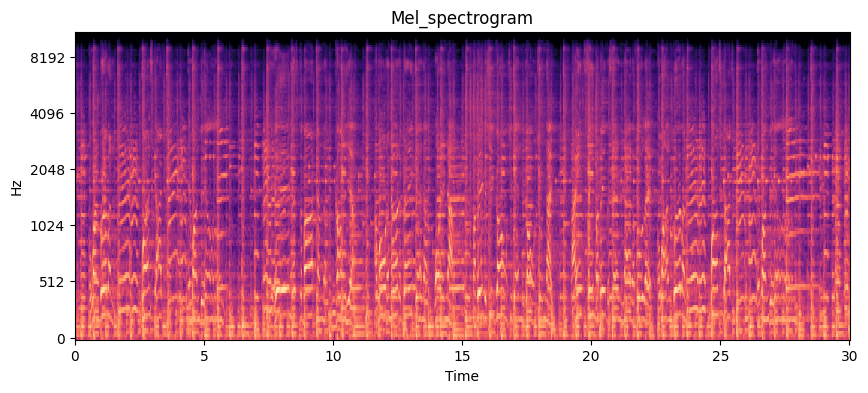

In [7]:
plot_mel_spectrogram(y,sr)

In [8]:
def plot_chunks(y, sr):
    chunk_duration = 4
    overlap_duration = 2
    
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr
    
    # print(f"{len(y)} - {chunk_samples} = {len(y) - chunk_samples}")
    # print(f"{chunk_samples} - {overlap_samples} = {chunk_samples - overlap_samples}")
    
    num_chunks = int(np.ceil((len(y) - chunk_samples)/(chunk_samples-overlap_samples))) + 1
    print(num_chunks)
    
    for i in range(num_chunks):
        start = i*(chunk_samples - overlap_samples)
        end = start + chunk_samples
        
        chunk = y[start:end]
        
        mel_spectrogram = librosa.feature.melspectrogram(y = chunk, sr=sr)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        plt.figure(figsize=(6,2))
        librosa.display.specshow(mel_spectrogram, sr=sr, x_axis = 'time', y_axis = 'mel')
        plt.title("Mel_spectrogram")
        plt.show()

In [11]:
def create_chunked_dataset(dataset_path, chunk_duration=4, overlap=0.5, target_shape = (128,128)):
    """
    Split each song into multiple chunks
    chunk_duration: duration of each chunk in seconds
    overlap: overlap between chunks (0.5 = 50% overlap)
    """
    
    all_spectrograms = []
    all_labels = []
    all_song_ids = []  # Track which song each chunk came from
    
    genres = os.listdir(dataset_path)
    genres.sort()
    
    for genre_idx, genre in enumerate(genres):
        genre_path = Path(dataset_path) / genre
        wav_files = list(genre_path.glob("*.wav"))
        
        print(f"Processing {genre}...")
        
        for song_idx, wav_file in enumerate(wav_files):
            try:
                # Load entire song
                y, sr = librosa.load(wav_file, sr=None)
                
                # Calculate chunk parameters
                chunk_samples = int(chunk_duration * sr)  # Convert to samples
                hop_samples = int(chunk_samples * (1 - overlap))
                
                # FIXED: Proper chunk calculation
                num_chunks = max(1, (len(y) - chunk_samples) // hop_samples + 1)
                
                for chunk_idx in range(num_chunks):
                    start_sample = chunk_idx * hop_samples
                    end_sample = start_sample + chunk_samples
                    
                    # Ensure we don't go beyond song length
                    if end_sample > len(y):
                        break
                        
                    # Extract audio chunk
                    y_chunk = y[start_sample:end_sample]
                    
                    # Create spectrogram for this chunk
                    mel = librosa.feature.melspectrogram(
                        y=y_chunk, sr=sr, n_mels=128, hop_length=512, n_fft=2048
                    )
                    log_mel = librosa.power_to_db(mel, ref=np.max)
                    
                    if log_mel.shape[1] < 128:
                        # Pad with silence
                        pad_width = 128 - log_mel.shape[1]
                        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), constant_values=-80)
                    else:
                        #Crop to 128
                        log_mel = log_mel[:, :128]
                        
                    # Normalize
                    epsilon = 1e-8
                    log_mel_normalized = (log_mel - log_mel.mean()) / (log_mel.std() + epsilon)
                    
                    all_spectrograms.append(log_mel_normalized)
                    all_labels.append(genre_idx)
                    all_song_ids.append(f"{genre}_{song_idx}")  # Track origin
                    
            except Exception as e:
                print(f"Error processing {wav_file}: {e}")
                continue
    
    X = np.array(all_spectrograms, dtype=np.float32)[..., np.newaxis]  # Add channel dimension
    y = np.array(all_labels)
    song_ids = np.array(all_song_ids)
    
    print(f"✅ Created chunked dataset: {X.shape}")
    print(f"   Total chunks: {len(X)}")
    print(f"   Unique songs: {len(np.unique(song_ids))}")
    
    return X, y, song_ids  # ✅ Return song_ids for proper splitting

# Create chunked dataset
X, y, song_ids = create_chunked_dataset(dataset_path)

Processing blues...
Processing classical...
Processing country...
Processing disco...
Processing hiphop...
Processing jazz...


C:\Users\supan\AppData\Local\Temp\ipykernel_30104\2968360990.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_file, sr=None)
c:\Users\supan\anaconda3\envs\music-genre-cnn\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing Data\genres_original\jazz\jazz.00054.wav: 
Processing metal...
Processing pop...
Processing reggae...
Processing rock...
✅ Created chunked dataset: (13977, 128, 128, 1)
   Total chunks: 13977
   Unique songs: 999


In [12]:
print('X shape= ', X.shape)
print('y shape= ', y.shape)

X shape=  (13977, 128, 128, 1)
y shape=  (13977,)


In [13]:
print(y.dtype)

int32


# Split dataset into Train, Test, Validation

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"✅ Simple split completed:")
print(f"   Train: {X_train.shape[0]} chunks")
print(f"   Val: {X_val.shape[0]} chunks") 
print(f"   Test: {X_test.shape[0]} chunks")

✅ Simple split completed:
   Train: 11181 chunks
   Val: 1398 chunks
   Test: 1398 chunks


# CNN MODEL ARCHITECTURE

In [15]:
def create_cnn_model(input_shape = (128,128, 1), num_classes = 10, learning_rate = 0.001):
    
    model = Sequential([
        Input(shape=input_shape),
        
        # Conv Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),  # Added for stability
        MaxPooling2D((2, 2)),
        
        # Conv Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Conv Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Conv Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        GlobalAveragePooling2D(),
        # Flatten(),
        Dropout(0.5),
        
        # Classification head - much smaller now
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Conservative optimizer
    optimizer = Adam(learning_rate=learning_rate)  # Reduced learning rate
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

# TRAIN MODEL

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks untuk improvement training
callbacks = [
    # Early Stopping: Stop training jika tidak membaik
    EarlyStopping(
        monitor='val_accuracy',    
        patience=8,               
        restore_best_weights=True, 
        verbose=1
    ),
    
    # Reduce Learning Rate: Kurangi LR jika stagnan
    ReduceLROnPlateau(
        monitor='val_loss',        
        factor=0.5,                
        patience=5,                
        min_lr=1e-7,          
        cooldown=2,
        verbose=1
    ),
    
    # Model Checkpoint: Simpan model terbaik
    ModelCheckpoint(
        'best_model.h5',           # Nama file untuk disimpan 
        monitor='val_accuracy',    # Monitor validation accuracy
        save_best_only=True,       # Hanya simpan yang terbaik
        mode='max',                # Maximize accuracy
        verbose=1
    )
]

print("✅ Callbacks setup completed")

✅ Callbacks setup completed


In [17]:
# Training parameters
EPOCHS = 100

# Training dengan data generators
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data = (X_val,y_val),              
    callbacks=callbacks,           
    verbose=1                       
)

Epoch 1/100
350/350 [==============================] - ETA: 0s - loss: 1.4434 - accuracy: 0.5123
Epoch 1: val_accuracy improved from -inf to 0.20243, saving model to best_model.h5
350/350 [==============================] - 108s 305ms/step - loss: 1.4434 - accuracy: 0.5123 - val_loss: 4.3483 - val_accuracy: 0.2024 - lr: 0.0010
Epoch 2/100


c:\Users\supan\anaconda3\envs\music-genre-cnn\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


350/350 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.6717
Epoch 2: val_accuracy improved from 0.20243 to 0.48569, saving model to best_model.h5
350/350 [==============================] - 105s 299ms/step - loss: 0.9800 - accuracy: 0.6717 - val_loss: 2.0837 - val_accuracy: 0.4857 - lr: 0.0010
Epoch 3/100
350/350 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.7362
Epoch 3: val_accuracy improved from 0.48569 to 0.60300, saving model to best_model.h5
350/350 [==============================] - 105s 300ms/step - loss: 0.7898 - accuracy: 0.7362 - val_loss: 1.2260 - val_accuracy: 0.6030 - lr: 0.0010
Epoch 4/100
350/350 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7751
Epoch 4: val_accuracy improved from 0.60300 to 0.64664, saving model to best_model.h5
350/350 [==============================] - 107s 306ms/step - loss: 0.6644 - accuracy: 0.7751 - val_loss: 1.1011 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 5/100
350/350

In [18]:
print("✅ Training completed!")
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_loss = history.history['loss'][-1]
print(f"Final train acc: {final_train_acc:.3f}, val acc: {final_val_acc:.3f}")
print(f"Final train loss: {final_train_loss:.3f}, val loss: {final_val_loss:.3f}")

✅ Training completed!
Final train acc: 0.986, val acc: 0.956
Final train loss: 0.042, val loss: 0.136


In [19]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    
    ax1.plot(history.history['accuracy'], label = 'Training Accuracy', linewidth = 2)
    ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linewidth = 2)
    ax1.set_title('Model Accuracy', fontsize = 14, fontweight = 'bold')
    ax1.set_xlabel('Epoch', fontsize = 12)
    ax1.set_ylabel('Accuracy', fontsize = 12)
    ax1.legend()
    ax1.grid(True, alpha = 0.3)
    
    ax2.plot(history.history['loss'], label = 'Training loss', linewidth = 2)
    ax2.plot(history.history['val_loss'], label = 'Validation loss', linewidth = 2)
    ax2.set_title('Model Loss', fontsize = 14, fontweight = 'bold')
    ax2.set_xlabel('Epoch', fontsize = 12)
    ax2.set_ylabel('Loss', fontsize = 12)
    ax2.legend()
    ax2.grid(True, alpha = 0.3)
    

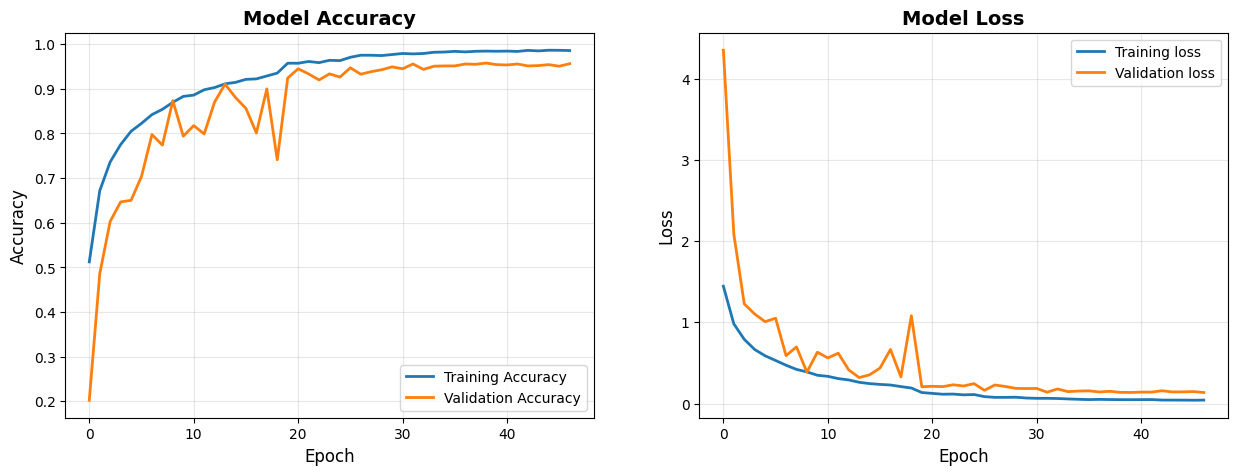

In [20]:
plot_training_history(history)

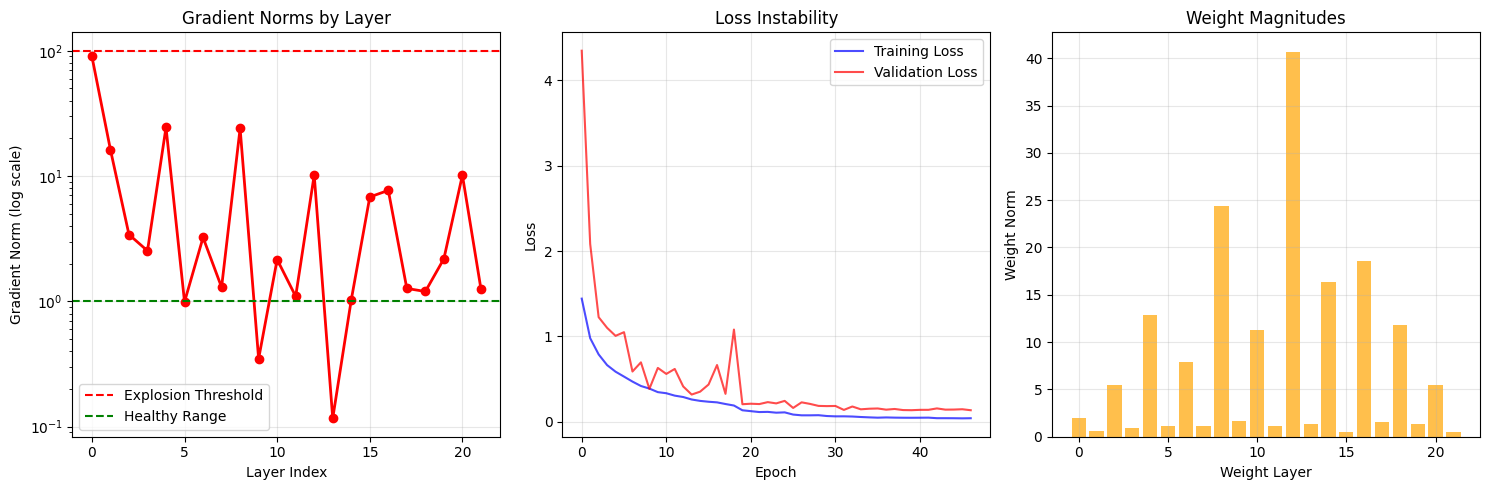

💥 GRADIENT EXPLOSION DIAGNOSIS:
   • Max gradient norm: 90.01
   • Explosion detected: False
   • NaN gradients: False


In [21]:
def visualize_exploding_gradients(history, model, X_sample, y_sample):
    """Visualize gradient explosion effects"""
    
    # Track gradient norms during training
    gradient_norms = []
    
    with tf.GradientTape() as tape:
        predictions = model(X_sample, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_sample, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    grad_norms = [tf.norm(g).numpy() for g in gradients if g is not None]
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Gradient norms
    plt.subplot(1, 3, 1)
    plt.plot(grad_norms, 'ro-', linewidth=2)
    plt.axhline(y=100, color='red', linestyle='--', label='Explosion Threshold')
    plt.axhline(y=1, color='green', linestyle='--', label='Healthy Range')
    plt.yscale('log')
    plt.title('Gradient Norms by Layer')
    plt.xlabel('Layer Index')
    plt.ylabel('Gradient Norm (log scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Loss instability
    plt.subplot(1, 3, 2)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], 'b-', label='Training Loss', alpha=0.7)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', alpha=0.7)
        plt.title('Loss Instability')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot 3: Weight magnitudes
    plt.subplot(1, 3, 3)
    weight_magnitudes = [tf.norm(w).numpy() for w in model.trainable_weights]
    plt.bar(range(len(weight_magnitudes)), weight_magnitudes, color='orange', alpha=0.7)
    plt.title('Weight Magnitudes')
    plt.xlabel('Weight Layer')
    plt.ylabel('Weight Norm')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print diagnosis
    print("💥 GRADIENT EXPLOSION DIAGNOSIS:")
    max_grad = max(grad_norms) if grad_norms else 0
    print(f"   • Max gradient norm: {max_grad:.2f}")
    print(f"   • Explosion detected: {max_grad > 1000}")
    print(f"   • NaN gradients: {any(np.isnan(norm) for norm in grad_norms)}")

# Run visualization
visualize_exploding_gradients(history, model, X_train[:32], y_train[:32])

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [33]:
from sklearn.calibration import calibration_curve
genres_name = os.listdir(dataset_path)
genres_name.sort()
y_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

In [34]:
def report_model_on_test_dataset(y_pred, y_test, genres_name):
    
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, 
                                      target_names=genres_name,))
    
    print("\n📋 Confusion Matrix Report:")
    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap="Blues")


📋 Classification Report:
              precision    recall  f1-score   support

       blues       0.99      0.91      0.95       151
   classical       1.00      0.93      0.97       150
     country       0.92      0.98      0.95       131
       disco       0.98      0.99      0.98       139
      hiphop       0.96      0.96      0.96       140
        jazz       0.93      0.99      0.96       130
       metal       0.98      0.98      0.98       140
         pop       0.99      0.97      0.98       143
      reggae       0.89      0.98      0.94       127
        rock       0.96      0.91      0.93       147

    accuracy                           0.96      1398
   macro avg       0.96      0.96      0.96      1398
weighted avg       0.96      0.96      0.96      1398


📋 Confusion Matrix Report:


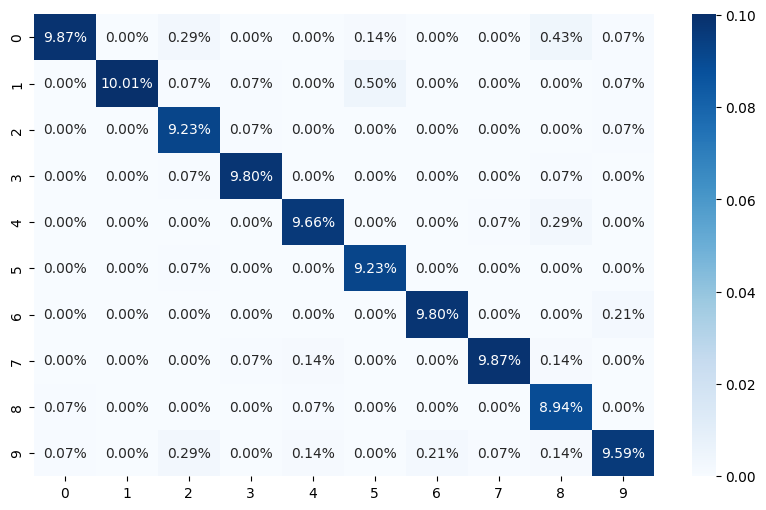

In [35]:
report_model_on_test_dataset(y_test, y_pred, genres_name)

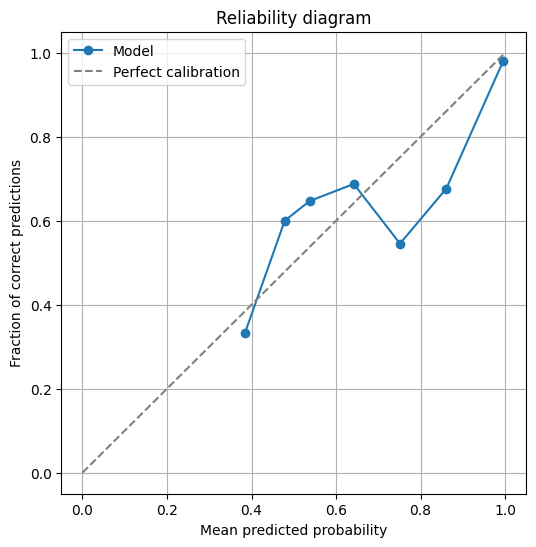

In [37]:
# Check reliability diagram
# y_prob: NxC output softmax (probabilitas per kelas)
def reliability_diagram_plot(y_proba, y_test):
    
    confs = y_proba[np.arange(len(y_proba)), y_pred] 
    correct = (y_pred == y_test).astype(int)  # 1 kalau benar, 0 kalau salah
    prob_true, prob_pred = calibration_curve(correct, confs, n_bins=10)  

    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfect calibration')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of correct predictions')
    plt.title('Reliability diagram')
    plt.legend()
    plt.grid(True)
    plt.show()

reliability_diagram_plot(y_proba, y_test)


In [39]:
def compute_ece(y_true, y_prob, n_bins=10):
    preds = np.argmax(y_prob, axis=1)
    confs = y_prob[np.arange(len(y_prob)), preds]
    accuracies = (preds == y_true).astype(int)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        mask = (confs > bins[i]) & (confs <= bins[i+1])
        if mask.sum() == 0:
            continue
        acc_in_bin = accuracies[mask].mean()
        conf_in_bin = confs[mask].mean()
        ece += (mask.sum() / len(confs)) * abs(acc_in_bin - conf_in_bin)
    return ece
print(f"Expected caliberation Error: {compute_ece(y_test, y_proba):.3f}")

Expected caliberation Error: 0.022


In [ ]:
# test model on single music:
test_path = "Data/genres_original/blues/blues.00000.wav"
    
y, sr = librosa.load(test_path, sr=22050)
        
    # Create spectrogram (same as training)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512, n_fft=2048)
log_mel = librosa.power_to_db(mel, ref=np.max)
        
    # Ensure 128x128 shape
if log_mel.shape[1] < 128:
    log_mel = np.pad(log_mel, ((0, 0), (0, 128 - log_mel.shape[1])), constant_values=-80)
else:
    log_mel = log_mel[:, :128]
        
    # Normalize
epsilon = 1e-8
log_mel_normalized = (log_mel - log_mel.mean()) / (log_mel.std() + epsilon)
        
    # Reshape for model (add batch and channel dimensions)
X_input = log_mel_normalized[np.newaxis, ..., np.newaxis]
        
# Predict
model = load_model("best_model.h5")
prediction = model.predict(X_input)
predicted_class = np.argmax(prediction[0])
confidence_scores = np.max(prediction[0])
print(f"Sample: Predicted class {genres_name[predicted_class]} with {confidence_scores:.2%} confidence")

1/1 [==============================] - 0s 83ms/step
Sample: Predicted class blues with 100.00% confidence
